In [1]:
from factor_repository.repositories import FactorRepositorySP
from factor_repository.repositories import FactorRepositoryAG
from factor_repository.repositories import FactorRepositoryCU
from factor_repository.repositories import FactorRepositoryFU
from factor_repository.repositories import FactorRepositoryHC
from factor_repository.repositories import FactorRepositoryRU
from factor_repository.repositories import FactorRepositoryRB
from factor_repository.repositories import FactorRepositoryTF


import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
fr = FactorRepositoryAG(20230701, 20240701, src_root=r'C:\Ter\source')
# fr = FactorRepositorySP(20230701, 20240701, src_root=r'C:\Ter\source')
# fr = FactorRepositoryCU(20230701, 20240701, src_root=r'C:\Ter\source')
# fr = FactorRepositoryFU(20230701, 20240701, src_root=r'C:\Ter\source')
# fr = FactorRepositoryHC(20230701, 20240701, src_root=r'C:\Ter\source')
# fr = FactorRepositoryRB(20230701, 20240701, src_root=r'C:\Ter\source')
# fr = FactorRepositoryRU(20230701, 20240701, src_root=r'C:\Ter\source')


In [4]:
# def BAV_diff_transform(tick_data, div=15,window_size=10):
#     tick_data['BAV_diff'] = tick_data['BidVolume1'].diff(window_size) - tick_data['AskVolume1'].diff(window_size)
#     # tick_data['BAV_diff_transform'] = tick_data['BAV_diff']
#     # tick_data['BAV_diff_transform'].fillna(0,inplace=True)
#     tick_data['BAV_diff_transform'] = (
#     1
#     + 0.3 * (np.abs(tick_data['BAV_diff']) >= 6*div)
#     * np.log(np.abs(tick_data['BAV_diff'] / (6*div)))
# ) * (1 / (1 + np.exp(-tick_data['BAV_diff'] / div)) - 0.5)
#     tick_data['BAV_diff_transform'].fillna(0,inplace=True)

In [5]:
def weighted_price(df):
    weighted = (df['AskPrice1']*df['BidVolume1'] + df['BidPrice1']*df['AskVolume1'])/(df['BidVolume1'] + df['AskVolume1'])
    weighted = weighted.astype(float)
    return weighted
def weighted_factor(table):
    table['weighted_price'] = weighted_price(table)
    table['weighted_factor'] = table['weighted_price'] - table['mid_price']

In [6]:
def std_factor(table,factor_name):
    table[factor_name] = (table[factor_name] - table[factor_name].mean())/table[factor_name].std()

In [7]:
def process_fr(table,factor):
    mask = (table[['AskPrice1','AskPrice2','AskPrice3','AskPrice4','AskPrice5','BidPrice1','BidPrice2','BidPrice3','BidPrice4','BidPrice5']]==0).any(axis=1)
    table[factor] = table[factor].where(~mask,0)

In [8]:
def BAV_diff_transform(tick_data, div=15):
    tick_data['BAV_diff'] = tick_data['BidVolume1'].diff() - tick_data['AskVolume1'].diff()
    # tick_data['BAV_diff_transform'] = tick_data['BAV_diff']
    # tick_data['BAV_diff_transform'].fillna(0,inplace=True)
    tick_data['BAV_diff_transform'] = (
    1
    + 0.2 * (np.abs(tick_data['BAV_diff']) >= 6*div)
    * np.log(np.abs(tick_data['BAV_diff'] / (6*div)))
) * (1 / (1 + np.exp(-tick_data['BAV_diff'] / div)) - 0.5)
    tick_data['BAV_diff_transform'].fillna(0,inplace=True)
    process_fr(tick_data,'BAV_diff_transform')


In [9]:
def slope_factor(table):
    table['Bid_Slope'] = table['BidVolume1'].diff()/(table['BidPrice1'].diff()+0.001)
    table['std_Bid_Slope'] = (table['Bid_Slope'] - table['Bid_Slope'].rolling(120).mean())/table['Bid_Slope'].rolling(120).std()
    table['Ask_Slope'] = table['AskVolume1'].diff()/(table['AskPrice1'].diff()+0.001)
    table['std_Ask_Slope'] = (table['Ask_Slope'] - table['Ask_Slope'].rolling(120).mean())/table['Ask_Slope'].rolling(120).std()
    table['slope_factor'] = table['std_Bid_Slope'] - table['std_Ask_Slope']
    table['slope_factor'].replace([np.inf, -np.inf], np.nan, inplace=True)
    table['slope_factor'].fillna(0,inplace=True)


In [10]:
def Volume_Order_Imbalance(table):
    table['delta_vol_Bid'] = table['BidVolume1'].diff() * (table['BidPrice1'] == table['BidPrice1'].shift(1)) + table['BidVolume1'] *(table['BidPrice1'] > table['BidPrice1'].shift(1)) + (table['BidVolume1']-table['BidVolume2'].shift(1)) * (table['BidPrice1'] < table['BidPrice1'].shift(1))
    table['delta_vol_Ask'] = table['AskVolume1'].diff() * (table['AskPrice1'] == table['AskPrice1'].shift(1)) + table['AskVolume1'] *(table['AskPrice1'] < table['AskPrice1'].shift(1)) + (table['AskVolume1']-table['AskVolume2'].shift(1)) * (table['AskPrice1'] > table['AskPrice1'].shift(1))
    table['Volume_Order_Imbalance'] = table['delta_vol_Bid'] - table['delta_vol_Ask']
    table['Volume_Order_Imbalance'].fillna(0,inplace=True)
    process_fr(table,'Volume_Order_Imbalance')


In [11]:
# def Volume_Order_Imbalance_SP(table):
#     table['delta_vol_Bid'] = table['BidVolume1'].diff() * (table['BidPrice1'] == table['BidPrice1'].shift(1)) + table['BidVolume1'] *(table['BidPrice1'] > table['BidPrice1'].shift(1)) + (table['BidVolume1']-table['BidVolume2'].shift(1)) * (table['BidPrice1'] < table['BidPrice1'].shift(1))
#     table['delta_vol_Ask'] = table['AskVolume1'].diff() * (table['AskPrice1'] == table['AskPrice1'].shift(1)) + table['AskVolume1'] *(table['AskPrice1'] < table['AskPrice1'].shift(1)) + (table['AskVolume1']-table['AskVolume2'].shift(1)) * (table['AskPrice1'] > table['AskPrice1'].shift(1))
#     table['std_factor'] = table['delta_vol_Bid'] - table['delta_vol_Ask']
#     table['Volume_Order_Imbalance_SP'] = (
#     1
#     + 0.2 * (np.abs(table['std_factor']) >= 25)
#     * np.log(np.abs(table['std_factor'] / 25))
#     ) * (1/(1+np.exp(-table['std_factor']/5)) - 0.5)
#     table['Volume_Order_Imbalance_SP'].fillna(0,inplace=True)    

In [12]:
# def std_factor_transform(table):
#     table['current_avg_price'] = table['Turnover'] / table['Volume']
#     table['current_avg_price'].replace([np.inf, -np.inf], np.nan, inplace=True)
#     table['current_avg_price'].fillna(method='ffill',inplace=True)
#     table['mpb'] = table['current_avg_price'] - table['mid_price']
#     table['mpb'].replace([np.inf, -np.inf], np.nan, inplace=True)
#     table['mpb'].fillna(0,inplace=True)
#     # table['sign'] = np.sign(table['current_avg_price'] - table['mid_price'])
#     table['std_factor'] = table['Volume'].rolling(5).std() * table['mpb']
#     table['std_factor_transform'] =  (
# 1
# + 0.2 * (np.abs(table['std_factor']) >= 25)
# * np.log(np.abs(table['std_factor'] / 25))
# ) * (1/(1+np.exp(-table['std_factor']/5)) - 0.5)
#     table['std_factor_transform'].fillna(0,inplace = True)


In [13]:
# def current_volume_factor(table):
#     table['current_avg_price'] = table['Turnover'] / table['Volume']
#     table['current_avg_price'].replace([np.inf, -np.inf], np.nan, inplace=True)
#     table['current_avg_price'].fillna(method='ffill',inplace=True)
#     table['sign'] = np.sign(2*table['current_avg_price']-table['AskPrice1']-table['BidPrice1'])
#     table['std_factor'] = table['sign'] * table['Volume']
#     table['current_volume_factor'] = (
#     1
#     - 0.2 * (np.abs(table['std_factor']) >= 50)
#     * np.log(np.abs(table['std_factor'] / 50))
#     ) * (1/(1+np.exp(-table['std_factor']/10)) - 0.5)
#     table['current_volume_factor'].fillna(0,inplace=True)


In [14]:
def press_factor(table):
    table['current_avg_price'] = table['Turnover'] / table['Volume']
    table['current_avg_price'].replace([np.inf, -np.inf], np.nan, inplace=True)
    table['current_avg_price'].fillna(method='ffill',inplace=True)

    ask_weights = [f'Askweight{i}' for i in range(1, 6)]
    bid_weights = [f'Bidweight{i}' for i in range(1, 6)]
    ask_volumes = [f'AskVolume{i}' for i in range(1, 6)]
    bid_volumes = [f'BidVolume{i}' for i in range(1, 6)]

    # 计算 Askweight 和 Bidweight
    for i in range(5):
        table[ask_weights[i]] = table['current_avg_price'] / (table[f'AskPrice{i+1}'] - table['current_avg_price'] + 0.00000123787)
        table[bid_weights[i]] = -table['current_avg_price'] / (table[f'BidPrice{i+1}'] - table['current_avg_price'] + 0.00000123787)

    # 计算卖盘压力 press_ask
    ask_weight_sum = table[ask_weights].sum(axis=1)
    table['press_ask'] = sum(table[ask_volumes[i]] * table[ask_weights[i]] for i in range(5)) / ask_weight_sum

    # 计算买盘压力 press_bid
    bid_weight_sum = table[bid_weights].sum(axis=1)
    table['press_bid'] = sum(table[bid_volumes[i]] * table[bid_weights[i]] for i in range(5)) / bid_weight_sum
    

    # 计算因子 factor
    table['press_factor'] = -np.log(table['press_ask']/table['press_bid'])

    # 填充缺失值
    table['press_factor'].fillna(0, inplace=True)



In [15]:
def log_base_factor(table):
    table['Bid_factor'] = table['BidVolume1']/table['BidVolume1'].rolling(60).mean()
    table['Ask_factor'] = table['AskVolume1']/table['AskVolume1'].rolling(60).mean()
    table['log_base_factor'] = np.log(table['Bid_factor']/table['Ask_factor'])
    table['log_base_factor'].fillna(0,inplace=True)

In [16]:
def skew_factor(table):
    columns_to_adjust = ['BidVolume1', 'BidVolume2', 'BidVolume3', 'BidVolume4', 'BidVolume5']
    Bid_volumes = table[columns_to_adjust]
    # Bid_volumes['mean'] = Bid_volumes.mean(axis=1)
    # Bid_volumes[columns_to_adjust] = Bid_volumes[columns_to_adjust].subtract(Bid_volumes['mean'],axis=0)
    # 提取数值数据为 NumPy 数组
    values = Bid_volumes[columns_to_adjust].values

    # 计算均值、标准差和偏度
    means = np.mean(values, axis=1)
    stds = np.std(values, axis=1, ddof=1)
    skewness = np.sum(((values - means[:, np.newaxis]) / stds[:, np.newaxis])**3, axis=1) / values.shape[1]

    # 将偏度结果存入 DataFrame
    Bid_volumes['skewness'] = skewness


    columns_to_adjust = ['AskVolume1', 'AskVolume2', 'AskVolume3', 'AskVolume4', 'AskVolume5']
    Ask_volumes = table[columns_to_adjust]
    # Ask_volumes['mean'] = Ask_volumes.mean(axis=1)
    # Ask_volumes[columns_to_adjust] = Ask_volumes[columns_to_adjust].subtract(Ask_volumes['mean'],axis=0)
    # 提取数值数据为 NumPy 数组
    values = Ask_volumes[columns_to_adjust].values

    # 计算均值、标准差和偏度
    means = np.mean(values, axis=1)
    stds = np.std(values, axis=1, ddof=1)
    skewness = np.sum(((values - means[:, np.newaxis]) / stds[:, np.newaxis])**3, axis=1) / values.shape[1]

    # 将偏度结果存入 DataFrame
    Ask_volumes['skewness'] = skewness

    table['skew_factor'] = Bid_volumes['skewness']-Ask_volumes['skewness']
    
    table['skew_factor'].fillna(0,inplace=True)

In [17]:
def Max_Volume_diff(table):
    table['Max_Volume_diff'] = -np.log(np.abs((table['BidVolume1'] - table[['BidVolume1', 'BidVolume2', 'BidVolume3', 'BidVolume4', 'BidVolume5']].max(axis=1))/(table['AskVolume1'] - table[['AskVolume1', 'AskVolume2', 'AskVolume3', 'AskVolume4', 'AskVolume5']].max(axis=1))))
    table['Max_Volume_diff'].replace([np.inf, -np.inf], np.nan, inplace=True)
    table['Max_Volume_diff'].fillna(0,inplace=True)

In [18]:
def pending_vol_ratio_factor(table , scalar = 0.1):
    table['ratio'] = table['BidVolume1']/(table['BidVolume1'] + table['AskVolume1'])
    table['pending_vol_ratio_factor'] = scalar * table['BidPrice1'].diff(2)/(table['BidPrice1'] - table['BidPrice2']) + table['ratio'].diff(2)
    table['pending_vol_ratio_factor'].fillna(0,inplace=True)
    process_fr(table,'pending_vol_ratio_factor')


In [19]:
# def ratio_factor_transform(table):
#     table['ratio'] = table['BidVolume1']/(table['BidVolume1'] + table['AskVolume1'])
#     table['factor'] = (np.abs(table['ratio'].diff()) + 1) * (table['BidPrice1'].diff() > 0) + table['ratio'].diff() * (table['BidPrice1'].diff() == 0) - (np.abs(table['ratio'].diff()) + 1) * (table['BidPrice1'].diff() < 0)
#     table['ratio_factor_transform'] = -0.2348*table['factor']**3 + -0.0154*table['factor']**2 + 0.5463*table['factor']
#     table['ratio_factor_transform'].fillna(0,inplace=True)

In [20]:
def sign_factor(table):
    table['BidVolume'] = table[['BidVolume1','BidVolume2','BidVolume3','BidVolume4','BidVolume5']].sum(axis=1)
    table['AskVolume'] = table[['AskVolume1','AskVolume2','AskVolume3','AskVolume4','AskVolume5']].sum(axis=1)
    table['sign_factor'] = table['BidVolume'].diff()*(table['BidPrice1'] <= table['BidPrice1'].rolling(8,min_periods=1).min()) - table['AskVolume'].diff()*(table['AskPrice1'].rolling(8,min_periods=1).max() <= table['AskPrice1'])
    table['sign_factor'].fillna(0,inplace=True)

In [21]:
def current_volume_factor(table):
    table['current_volume_factor'] = np.log(table['Volume'] + 1)
    table['current_volume_factor'].fillna(0, inplace=True)

In [22]:
def submit_price_imbalance(table):
    table['mid_price'] = (table['BidPrice1'] + table['AskPrice1'])/2
    table['BidVolume'] = table[['BidVolume1','BidVolume2','BidVolume3','BidVolume4','BidVolume5']].sum(axis=1)
    table['AskVolume'] = table[['AskVolume1','AskVolume2','AskVolume3','AskVolume4','AskVolume5']].sum(axis=1)
    table['Bid_submit_price'] = (table['BidPrice1'] * table['BidVolume1'] + table['BidPrice2'] * table['BidVolume2'] + table['BidPrice3'] * table['BidVolume3'] + table['BidPrice4'] * table['BidVolume4'] + table['BidPrice5'] * table['BidVolume5'])/table['BidVolume']
    table['Ask_submit_price'] = (table['AskPrice1'] * table['AskVolume1'] + table['AskPrice2'] * table['AskVolume2'] + table['AskPrice3'] * table['AskVolume3'] + table['AskPrice4'] * table['AskVolume4'] + table['AskPrice5'] * table['AskVolume5'])/table['AskVolume']
    table['submit_price'] = table['Ask_submit_price'] + table['Bid_submit_price'] - 2 * table['mid_price']
    table['submit_price_imbalance'] = (table['submit_price'] - table['submit_price'].rolling(10,min_periods=1).mean())/table['submit_price'].rolling(10,min_periods=1).std()
    table['submit_price_imbalance'].replace([np.inf, -np.inf], np.nan, inplace=True)
    table['submit_price_imbalance'].fillna(0, inplace=True)
    process_fr(table,'submit_price_imbalance')

    # std_factor(table,'submit_price_imbalance')

In [23]:
def relative_vol_ratio_imbalance(table):
    table['BidVolume'] = table[['BidVolume1','BidVolume2','BidVolume3','BidVolume4','BidVolume5']].sum(axis=1)
    table['AskVolume'] = table[['AskVolume1','AskVolume2','AskVolume3','AskVolume4','AskVolume5']].sum(axis=1)
    table['Bid_ratio'] = table['BidVolume']/table['BidVolume1']
    table['Ask_ratio'] = table['AskVolume']/table['AskVolume1']
    table['relative_vol_ratio_diff'] = table['Ask_ratio'] - table['Bid_ratio']
    table['relative_vol_ratio_imbalance'] = (table['relative_vol_ratio_diff'] - table['relative_vol_ratio_diff'].rolling(20,min_periods=1).mean())/table['relative_vol_ratio_diff'].rolling(20,min_periods=1).std()
    table['relative_vol_ratio_imbalance'].replace([np.inf, -np.inf], np.nan, inplace=True)
    table['relative_vol_ratio_imbalance'].fillna(0,inplace=True)
    process_fr(table,'relative_vol_ratio_imbalance')



In [24]:
# from sklearn.linear_model import LinearRegression
# def linear_combination(table):
#     model = LinearRegression()
#     X = table[['BAV_diff_transform','Volume_Order_Imbalance','Base_factor','relative_vol_ratio_imbalance']]
#     y = table['frt_120']
    
#     model.fit(X, y)

#     # 提取回归系数
#     coefficients = model.coef_

#     # 得到综合因子值 F：
#     table['linear_combination'] = np.dot(X, coefficients)

In [25]:
def linear_combination(table,factors,weights):
    X = table[factors]
    table['linear_combination'] = np.dot(X, weights)
    table['linear_combination'].fillna(0,inplace=True)

In [26]:
def Base_factor(table):
    table['Base_factor'] = -(table['AskVolume1']-table['BidVolume1'])/(table['AskVolume1']+table['BidVolume1'])
    table['Base_factor'].replace([np.inf, -np.inf], np.nan, inplace=True)
    table['Base_factor'].fillna(0,inplace=True)
    process_fr(table,'Base_factor')


In [27]:
def max_vol_ratio_imbalance(table):
    table['max_vol_ratio_imbalance'] = -table[['BidVolume1', 'BidVolume2', 'BidVolume3', 'BidVolume4', 'BidVolume5']].max(axis=1)/table['BidVolume1'] + table[['AskVolume1', 'AskVolume2', 'AskVolume3', 'AskVolume4', 'AskVolume5']].max(axis=1)/table['AskVolume1']
    table['max_vol_ratio_imbalance'].fillna(0,inplace=True)

In [28]:
def vol_entropy_imbalance(table,weights=[0.2,0.2,0.2,0.2,0.2]):
    table['BidVolume'] = table[['BidVolume1','BidVolume2','BidVolume3','BidVolume4','BidVolume5']].sum(axis=1)
    table['AskVolume'] = table[['AskVolume1','AskVolume2','AskVolume3','AskVolume4','AskVolume5']].sum(axis=1)
    table['Bid_entropy'] = 0
    table['Ask_entropy'] = 0
    for i in range(1,6):
        p = table[f'BidVolume{i}']/table['BidVolume']
        table['Bid_entropy'] -= weights[i-1] * p * np.log2(p)
        q = table[f'AskVolume{i}']/table['AskVolume']
        table['Ask_entropy'] -= weights[i-1] * q * np.log2(q)
    table['vol_entropy_imbalance'] = table['Bid_entropy'] - table['Ask_entropy']
    table['vol_entropy_imbalance'].fillna(0,inplace=True)

In [29]:
def vol_entropy_diff(table):
    table['BidVolume'] = table[['BidVolume1','BidVolume2','BidVolume3','BidVolume4','BidVolume5']].sum(axis=1)
    table['AskVolume'] = table[['AskVolume1','AskVolume2','AskVolume3','AskVolume4','AskVolume5']].sum(axis=1)
    table['Bid_entropy'] = 0
    table['Ask_entropy'] = 0
    for i in range(1,6):
        p = table[f'BidVolume{i}']/table['BidVolume']
        table['Bid_entropy'] -= p * np.log2(p)
        q = table[f'AskVolume{i}']/table['AskVolume']
        table['Ask_entropy'] -= q * np.log2(q)
    table['vol_entropy_imbalance'] = table['Bid_entropy'].diff() - table['Ask_entropy'].diff()
    table['vol_entropy_imbalance'].fillna(0,inplace=True)

In [30]:
def frt_10(table):
    table['frt_10'] = -table['mid_price'].diff(-10)
    table['frt_10'].fillna(0,inplace=True)
def frt_30(table):
    table['frt_30'] = -table['mid_price'].diff(-30)
    table['frt_30'].fillna(0,inplace=True)
def frt_50(table):
    table['frt_50'] = -table['mid_price'].diff(-50)
    table['frt_50'].fillna(0,inplace=True)
def frt_200(table):
    table['frt_200'] = -table['mid_price'].diff(-200)
    table['frt_200'].fillna(0,inplace=True)

In [31]:
# fr.get_concat_tick_data().columns

In [32]:
# fr.calc_init_factors()
# fr.factor_install([pending_vol_ratio_factor,submit_price_imbalance,relative_vol_ratio_imbalance,log_base_factor,slope_factor,press_factor])

In [33]:
with open('test.csv','w+') as f:
    f.writelines(f'day_ret,ori_ret\n')

In [34]:
factor_columns = ['Base_factor','BAV_diff_transform','Volume_Order_Imbalance','pending_vol_ratio_factor','submit_price_imbalance','relative_vol_ratio_imbalance']
factor = [Base_factor,BAV_diff_transform,Volume_Order_Imbalance,pending_vol_ratio_factor,submit_price_imbalance,relative_vol_ratio_imbalance]
fr.factor_install(factor)

# # OLS
# weights_ag_with_base = [0.121132,0.034276,0.098189,0.017293,0.039233,0.028795]
# weights_ag_without_base = [0.040300,0.093085,0.046340,0.049040,0.074835]

# # Cauchy负对数似然函数
# weights_ag_with_base = [0.168667,0.022833,0.029826,-0.007750,0.038724,0.020238]
# weights_sp_with_base = [0.114691,0.019645,0.014361,0.010492,0.034487,0.020051]
# weights_rb_with_base = [0.192568,0.018403,0.038290,-0.012230,0.036438,0.018750]
# weights_ru_with_base = [0.037670,0.007149,0.001673,0.001302,0.011480,0.008630]
# weights_hc_with_base = [0.193996,0.015416,0.030733,-0.016208,0.036049,0.025127]
# weights_fu_with_base = [0.152164,0.026196,0.016058,0.001225,0.041259,0.016663]
# weights_cu_with_base = [0.028131,0.006124,0.003551,0.004653,0.008212,0.000385]


weights_ag_with_base = [0.342012, 0.081143, 0.000975, -0.0437, 0.032051, 0.013801]
weights_sp_with_base = [0.282894, 0.08154, 0.000354, 0.055818, 0.026845, 0.014672]
weights_rb_with_base =[0.381709, 0.046025, 0.000297, -0.069153, 0.02842, 0.014444]
weights_ru_with_base = [0.099201, 0.036513, 7.5e-05, 0.004346, 0.009079, 0.007237]
weights_hc_with_base = [0.346211, 0.04647, 0.000491, -0.076761, 0.028287, 0.019737]
weights_fu_with_base = [0.353632, 0.097925, 0.00033, 0.005682, 0.032828, 0.012982]
weights_cu_with_base = [0.047904, 0.031309, 0.000289, -0.016641, 0.00668, 0.000491]



# Cauchy负对数似然函数

fr.factor_install(linear_combination,factors=factor_columns,weights=weights_ag_with_base)

Factor Analysis
factor name: linear_combination
symbol: ag
target: frt_120
+---------------------+-----------------------------------------------+
| factor mean         | 0.000291                                      |
+---------------------+-----------------------------------------------+
| factor std          | 0.214184                                      |
+---------------------+-----------------------------------------------+
| corr                | corr=0.0598, corr_len=0.0881, corr_sgn=0.0846 |
+---------------------+-----------------------------------------------+
| R_square            | 0.003580                                      |
+---------------------+-----------------------------------------------+
| backtest value mean | 0.585715                                      |
+---------------------+-----------------------------------------------+
| backtest value std  | 1.315761                                      |
+---------------------+--------------------------------------

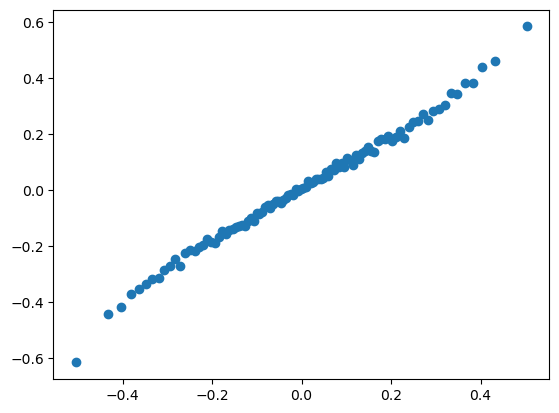

{'factor_mean': 0.00029142135668962005,
 'factor_std': 0.21418436307684116,
 'corr': 0.05983408015171702,
 'r_2': 0.0035803307693654807,
 'b_value': 0.5857153295119157,
 'factor_mean_list': factor_discrete
 0    -0.504508
 1    -0.432681
 2    -0.403963
 3    -0.382269
 4    -0.364158
         ...   
 95    0.364085
 96    0.382128
 97    0.403852
 98    0.432640
 99    0.503574
 Name: linear_combination, Length: 100, dtype: float64,
 'frt_mean': factor_discrete
 0    -0.615801
 1    -0.442127
 2    -0.418929
 3    -0.371682
 4    -0.352979
         ...   
 95    0.381175
 96    0.381497
 97    0.439059
 98    0.460644
 99    0.583595
 Name: frt_120, Length: 100, dtype: float64}

In [35]:
fr.factor_analysis('linear_combination','frt_120',bins = 100, threshold=0.01)

In [36]:
# fr.get_concat_tick_data()['linear_combination'].quantile([0.01,0.99])

最大回撤: -25104.00


<Axes: >

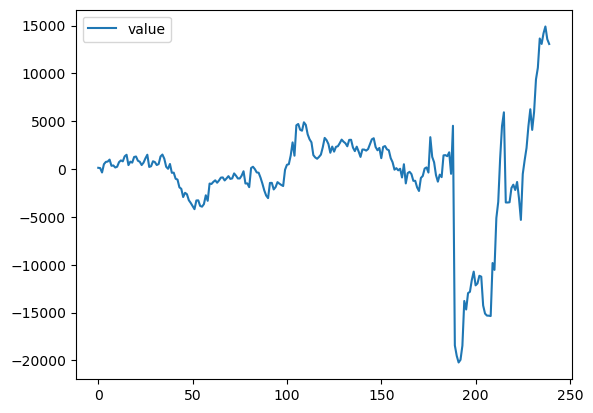

In [37]:
df = pd.read_csv('test.csv')
df['value'] = df['day_ret'].cumsum()
df['ori_value'] = df['ori_ret'].cumsum()
df['cumulative_max'] = df['value'].cummax()
df['drawdown'] = (df['value'] - df['cumulative_max'])
# 计算最大回撤
max_drawdown = df['drawdown'].min()
print(f"最大回撤: {max_drawdown:.2f}")
df[['value']].plot()

In [38]:
# with open('test.csv','w+') as f:
#     f.writelines(f'day_ret,ori_ret\n')

In [39]:
# fr.factor_analysis('vol_slice_imbalance','frt_120',bins = 100, threshold=0.01)

In [40]:
# df = pd.read_csv('test.csv')
# df['value'] = df['day_ret'].cumsum()
# df['ori_value'] = df['ori_ret'].cumsum()
# df['cumulative_max'] = df['value'].cummax()
# df['drawdown'] = (df['value'] - df['cumulative_max'])/df['cumulative_max']
# # 计算最大回撤
# max_drawdown = df['drawdown'].min()
# print(f"最大回撤: {max_drawdown:.2f}")
# df[['value']].plot()

In [41]:
# fr.factor_install(submit_price_imbalance)

In [42]:
# fr.factor_analysis('submit_price_imbalance','frt_120',bins = 100, threshold=0.01)

In [43]:
# fr.get_concat_tick_data()['relative_vol_ratio_imbalance'].quantile(0.01)

In [44]:
# fr.factor_install(slope_factor)
# fr.factor_analysis('slope_factor','frt_120',bins = 100, threshold=0.01)

In [45]:
# fr.factor_install(Volume_Order_Imbalance)
# fr.factor_analysis('Volume_Order_Imbalance','frt_120',bins = 100, threshold=0.01)

In [46]:
# fr.factor_install(pending_vol_ratio_factor)
# fr.factor_analysis('pending_vol_ratio_factor','frt_120',bins = 100, threshold=0.01)

In [47]:
# fr.get_concat_tick_data()[fr.factors+['frt_120']].corr()
# fr.get_concat_tick_data()[['BAV_diff_transform','Volume_Order_Imbalance','pending_vol_ratio_factor','relative_vol_ratio_imbalance','Base_factor']+['frt_60','frt_50','frt_40','frt_30','frt_20','frt_10']].corr()

In [48]:
# df1 = fr.get_concat_tick_data()[['AskVolume1','AskVolume2','AskVolume3','AskVolume4','AskVolume5','BidVolume1','BidVolume2','BidVolume3','BidVolume4','BidVolume5']+['exchange_time','trading_date'] + fr.factors]
# mask = (df1[['AskVolume1','AskVolume2','AskVolume3','AskVolume4','AskVolume5','BidVolume1','BidVolume2','BidVolume3','BidVolume4','BidVolume5']]==0).any(axis=1)

# df1 = fr.get_concat_tick_data()[['AskPrice1','AskPrice2','AskPrice3','AskPrice4','AskPrice5','BidPrice1','BidPrice2','BidPrice3','BidPrice4','BidPrice5']+['exchange_time','trading_date'] + fr.factors]
# mask = (df1[['AskPrice1','AskPrice2','AskPrice3','AskPrice4','AskPrice5','BidPrice1','BidPrice2','BidPrice3','BidPrice4','BidPrice5']]==0).any(axis=1)
# df1[fr.factors] = df1[fr.factors].where(~mask,0)
# df = df1[['exchange_time','trading_date'] + fr.factors]

In [49]:
# df = fr.get_concat_tick_data()[['frt_80','frt_100','frt_120']]

# 生成因子文件

In [50]:
# import pandas as pd

# def save_factor_h5_files(df,start_date,end_date):
#     for factor in df.columns[2:]:
#         sub_df = df[['exchange_time', 'trading_date', factor]].fillna(0)

#         time_range = f"{start_date}-{end_date}"
        
#         # 生成文件名
#         filename = f"AG-{factor}-{time_range}.h5"
        
#         # 保存为HDF5文件，使用pandas的to_hdf方法
#         try:
#             sub_df.to_hdf(filename, key=f'{factor}_data', mode='w', index=False)
#             print(f"成功保存文件: {filename}")
#         except Exception as e:
#             print(f"保存文件 {filename} 时出错: {e}")

# save_factor_h5_files(df,'20230701','20240701')

In [51]:
# def save_factor_parquet_files(df,symbol,start_date,end_date):
#     for factor in df.columns[2:]:
#         sub_df = df[['exchange_time', 'trading_date', factor]].fillna(0)

#         time_range = f"{start_date}-{end_date}"
        
#         # 生成文件名
#         filename = f"{symbol}-{factor}-{time_range}.parquet"

#         try:
#             sub_df.to_parquet(f'C:\Ter\\factor_parquet\{symbol}\{filename}')
#             print(f"成功保存文件: {filename}")
#         except Exception as e:
#             print(f"保存文件 {filename} 时出错: {e}")

# save_factor_parquet_files(df,'ru','20230701','20240701')

In [52]:
# with pd.HDFStore(r'C:\Ter\factor\AG-active_buy_sell_imbalance-20230701-20240701.h5') as store:
#     # 列出所有可用的键（因子名称+时间区间）
#     print("Available keys:", store.keys())

#     factor_data = store['active_buy_sell_imbalance_data']
    
#     # 打印读取的因子数据
#     print(factor_data)